In [1]:
# ============================================================================
# PART 1: INSTALLATION AND IMPORTS
# ============================================================================

# Install required packages (run in Colab)
import sys
!{sys.executable} -m pip install -q mne pywavelets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import signal
from scipy.stats import zscore
import mne
from mne.decoding import CSP
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, roc_auc_score, roc_curve)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("="*80)
print("MOTOR IMAGERY EEG DECODING ENHANCEMENT PROJECT")
print("Using PhysioNet Motor Movement/Imagery Database")
print("="*80)

MOTOR IMAGERY EEG DECODING ENHANCEMENT PROJECT
Using PhysioNet Motor Movement/Imagery Database


In [2]:
# ============================================================================
# PART 2: PHYSIONET DATA LOADING
# ============================================================================

print("\n[1/10] Loading PhysioNet Motor Imagery Dataset...")

def load_physionet_motor_imagery(subjects, runs, tmin=0, tmax=4, target_sfreq=128):
    import numpy as np
    import mne

    all_epochs = []
    all_labels = []
    all_subjects = []

    fixed_samples = None  # will be determined after first subject

    for subject in subjects:
        print(f"  Loading subject {subject}...", end=" ")

        try:
            # Load EDF files
            raw_files = eegbci.load_data(subject, runs, verbose=False)
            raw = concatenate_raws([read_raw_edf(f, preload=True, verbose=False)
                                   for f in raw_files])

            mne.datasets.eegbci.standardize(raw)

            # Resample
            raw.resample(target_sfreq)

            # Extract events
            events_all, event_dict = mne.events_from_annotations(raw, verbose=False)

            # Detect T1 (left) and T2 (right)
            event_id = {}
            for k, v in event_dict.items():
                if "T1" in k:
                    event_id["left"] = v
                if "T2" in k:
                    event_id["right"] = v

            if len(event_id) != 2:
                print("✗ Missing T1/T2")
                continue

            # Keep only left/right events
            events = events_all[np.isin(events_all[:, 2], list(event_id.values()))]
            if len(events) == 0:
                print("✗ No events")
                continue

            # Create epochs
            epochs = mne.Epochs(raw, events, event_id,
                                tmin=tmin, tmax=tmax,
                                baseline=None,
                                preload=True, verbose=False)

            X = epochs.get_data()     # (n_trials, n_channels, n_samples)
            y = (epochs.events[:, -1] == event_id["right"]).astype(int)

            # Set reference sample length
            if fixed_samples is None:
                fixed_samples = X.shape[2]
                print(f"(ref {fixed_samples})", end=" ")

            # Create padded/truncated fixed-length data
            fixed_X = np.zeros((X.shape[0], X.shape[1], fixed_samples))

            for i in range(X.shape[0]):
                s = X[i].shape[1]
                if s >= fixed_samples:
                    fixed_X[i] = X[i][:, :fixed_samples]
                else:
                    fixed_X[i, :, :s] = X[i]

            all_epochs.append(fixed_X)
            all_labels.append(y)
            all_subjects.append(np.full(len(y), subject))

            print(f"✓ {len(y)} trials")

        except Exception as e:
            print(f"✗ Error: {e}")
            continue

    # Safe concatenation
    X = np.concatenate(all_epochs, axis=0)
    y = np.concatenate(all_labels, axis=0)
    subjects = np.concatenate(all_subjects, axis=0)

    return X, y, subjects, target_sfreq, epochs.ch_names


# ============================== LOAD DATASET ==============================

subjects = list(range(1, 50))
runs = [4, 8, 12]

X_raw, y, subject_ids, sfreq, ch_names = load_physionet_motor_imagery(
    subjects, runs, tmin=0, tmax=4, target_sfreq=128
)

print(f"\n✓ Data loaded successfully!")
print(f"  Total trials: {X_raw.shape[0]}")
print(f"  Shape: {X_raw.shape}")
print(f"  Sampling rate (resampled): {sfreq}")
print(f"  Number of channels: {len(ch_names)}")
print(f"  Left={np.sum(y==0)}, Right={np.sum(y==1)}")
print(f"  Subjects used: {len(np.unique(subject_ids))}")

motor_channels = ['C3', 'Cz', 'C4', 'FC1', 'FC2', 'CP1', 'CP2']
motor_channel_idx = [i for i, ch in enumerate(ch_names) if ch in motor_channels]
print(f"  Motor cortex channels: {[ch_names[i] for i in motor_channel_idx]}")



[1/10] Loading PhysioNet Motor Imagery Dataset...
  Loading subject 1... (ref 513) ✓ 45 trials
  Loading subject 2... ✓ 45 trials
  Loading subject 3... ✓ 45 trials
  Loading subject 4... ✓ 45 trials
  Loading subject 5... ✓ 45 trials
  Loading subject 6... ✓ 45 trials
  Loading subject 7... ✓ 45 trials
  Loading subject 8... ✓ 45 trials
  Loading subject 9... ✓ 45 trials
  Loading subject 10... ✓ 45 trials
  Loading subject 11... ✓ 45 trials
  Loading subject 12... ✓ 45 trials
  Loading subject 13... ✓ 45 trials
  Loading subject 14... ✓ 45 trials
  Loading subject 15... ✓ 45 trials
  Loading subject 16... ✓ 45 trials
  Loading subject 17... ✓ 45 trials
  Loading subject 18... ✓ 45 trials
  Loading subject 19... ✓ 45 trials
  Loading subject 20... ✓ 45 trials
  Loading subject 21... ✓ 45 trials
  Loading subject 22... ✓ 45 trials
  Loading subject 23... ✓ 45 trials
  Loading subject 24... ✓ 45 trials
  Loading subject 25... ✓ 45 trials
  Loading subject 26... ✓ 45 trials
  Loading su

In [3]:
# ============================================================================
# PART 3: PREPROCESSING PIPELINE COMPARISON
# ============================================================================

print("\n[2/10] Applying Preprocessing Methods...")

class PreprocessingPipeline:
    """Different preprocessing strategies for motor imagery EEG"""

    @staticmethod
    def bandpass_filter(data, sfreq, l_freq=8, h_freq=30):
        """
        Bandpass filter to extract mu (8-12 Hz) and beta (13-30 Hz) rhythms
        These frequency bands are critical for motor imagery detection
        """
        sos = signal.butter(4, [l_freq, h_freq], btype='band',
                           fs=sfreq, output='sos')
        return signal.sosfiltfilt(sos, data, axis=-1)

    @staticmethod
    def baseline_correction(data):
        """Remove mean baseline from each trial"""
        return data - np.mean(data, axis=-1, keepdims=True)

    @staticmethod
    def artifact_removal_simple(data, threshold=100):
        """
        Simple artifact rejection based on amplitude threshold
        Removes trials with extreme values (likely artifacts)
        """
        max_vals = np.max(np.abs(data), axis=(1, 2))
        good_trials = max_vals < threshold
        return data[good_trials], good_trials

    @staticmethod
    def spatial_filtering_laplacian(data, ch_names):
        """
        Laplacian spatial filtering for motor cortex channels
        Enhances local activity by subtracting surrounding channels
        """
        # For simplicity, just return data as-is
        # In full implementation, compute Laplacian for C3, Cz, C4
        return data

    @staticmethod
    def csp_features(X_train, y_train, X_test, n_components=6):
        """
        Common Spatial Patterns (CSP) - optimal spatial filtering
        Maximizes variance difference between classes
        """
        csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)

        # Fit on training data
        X_train_csp = csp.fit_transform(X_train, y_train)
        X_test_csp = csp.transform(X_test)

        return X_train_csp, X_test_csp, csp

# Apply preprocessing methods
print("  Applying bandpass filter (8-30 Hz)...")
X_bp = PreprocessingPipeline.bandpass_filter(X_raw, sfreq)

print("  Applying baseline correction...")
X_bp_bc = PreprocessingPipeline.baseline_correction(X_bp)

print("  Removing artifacts...")
X_clean, good_trials = PreprocessingPipeline.artifact_removal_simple(X_bp_bc)
y_clean = y[good_trials]
subjects_clean = subject_ids[good_trials]
print(f"  Kept {len(X_clean)}/{len(X_bp_bc)} trials after artifact rejection")

# Create motor channels subset
X_motor = X_clean[:, motor_channel_idx, :]
print(f"  Extracted motor cortex channels: {X_motor.shape}")

# Store preprocessing variants
preprocessing_methods = {
    'Bandpass+CSP': X_clean,
    'MotorChannels+CSP': X_motor
}

print("  ✓ Preprocessing complete")


[2/10] Applying Preprocessing Methods...
  Applying bandpass filter (8-30 Hz)...
  Applying baseline correction...
  Removing artifacts...
  Kept 2200/2200 trials after artifact rejection
  Extracted motor cortex channels: (2200, 7, 513)
  ✓ Preprocessing complete


In [4]:
# ============================================================================
# PART 4: TRADITIONAL ML - OPTIMIZED (3-FOLD CV, 2 MODELS)
# ============================================================================

print("\n[3/8] Training Traditional ML Models (Optimized)...")

def evaluate_ml_model_fast(X, y, subjects, model, n_folds=3):
    """
    OPTIMIZED: Fast evaluation with reduced cross-validation folds
    """
    cv_scores = []
    unique_subjects = np.unique(subjects)
    subjects_to_test = unique_subjects[:n_folds]  # Test only first n subjects

    for test_subj in subjects_to_test:
        train_idx = subjects != test_subj
        test_idx = subjects == test_subj

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # CSP features
        X_train_csp, X_test_csp, _ = PreprocessingPipeline.csp_features(
            X_train, y_train, X_test, n_components=6
        )

        # Train and evaluate
        model.fit(X_train_csp, y_train)
        y_pred = model.predict(X_test_csp)
        acc = accuracy_score(y_test, y_pred)
        cv_scores.append(acc)

    return np.mean(cv_scores), np.std(cv_scores)

# OPTIMIZED: Test only 2 best models
ml_models = {
    'LDA': LinearDiscriminantAnalysis(),
    'SVM (RBF)': SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
}

ml_results = []

print(f"  Using 3-fold cross-validation (fast mode)")
for model_name, model in ml_models.items():
    print(f"  Training {model_name}...", end=" ")
    mean_acc, std_acc = evaluate_ml_model_fast(
        X_clean, y_clean, subjects_clean, model, n_folds=3
    )
    ml_results.append({
        'Preprocessing': 'Bandpass+CSP',
        'Model': model_name,
        'Accuracy': mean_acc,
        'Std': std_acc
    })
    print(f"{mean_acc:.3f} ± {std_acc:.3f}")

ml_results_df = pd.DataFrame(ml_results)


[3/8] Training Traditional ML Models (Optimized)...
  Using 3-fold cross-validation (fast mode)
  Training LDA... Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 1e+11  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 6

In [5]:
# ============================================================================
# PART 5: DEEP LEARNING - OPTIMIZED (REDUCED EPOCHS)
# ============================================================================

print("\n[4/8] Training Deep Learning Models (Optimized)...")

def build_eegnet(n_channels, n_samples, n_classes=2, dropoutRate=0.25):
    """EEGNet: Compact CNN for EEG-based BCIs"""
    input_layer = layers.Input(shape=(n_channels, n_samples, 1))

    # Block 1: Temporal convolution
    block1 = layers.Conv2D(8, (1, 64), padding='same', use_bias=False)(input_layer)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.DepthwiseConv2D((n_channels, 1), use_bias=False,
                                    depth_multiplier=2,
                                    depthwise_constraint=keras.constraints.max_norm(1.))(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.AveragePooling2D((1, 4))(block1)
    block1 = layers.Dropout(dropoutRate)(block1)

    # Block 2: Separable convolution
    block2 = layers.SeparableConv2D(16, (1, 16), padding='same', use_bias=False)(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.AveragePooling2D((1, 8))(block2)
    block2 = layers.Dropout(dropoutRate)(block2)

    # Classification
    flatten = layers.Flatten()(block2)
    dense = layers.Dense(n_classes, activation='softmax',
                        kernel_constraint=keras.constraints.max_norm(0.25))(flatten)

    return models.Model(inputs=input_layer, outputs=dense)

def build_shallowconvnet(n_channels, n_samples, n_classes=2):
    """ShallowConvNet: Simple but effective CNN"""
    input_layer = layers.Input(shape=(n_channels, n_samples, 1))

    conv1 = layers.Conv2D(40, (1, 25), use_bias=False)(input_layer)
    conv2 = layers.Conv2D(40, (n_channels, 1), use_bias=False,
                         kernel_constraint=keras.constraints.max_norm(2.))(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Lambda(lambda x: tf.square(x))(conv2)
    conv2 = layers.AveragePooling2D((1, 75), strides=(1, 15))(conv2)
    conv2 = layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 1e-6, 1e6)))(conv2)
    conv2 = layers.Dropout(0.5)(conv2)

    flatten = layers.Flatten()(conv2)
    dense = layers.Dense(n_classes, activation='softmax',
                        kernel_constraint=keras.constraints.max_norm(0.5))(flatten)

    return models.Model(inputs=input_layer, outputs=dense)

# Prepare data
X_dl = X_clean.copy()
n_channels, n_samples = X_dl.shape[1], X_dl.shape[2]

# Normalize (critical!)
print("  Normalizing data...")
for trial in range(X_dl.shape[0]):
    for ch in range(X_dl.shape[1]):
        X_dl[trial, ch, :] = zscore(X_dl[trial, ch, :])
X_dl = np.nan_to_num(X_dl)

# Reshape for CNN
X_dl = X_dl[..., np.newaxis]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_dl, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"  Train: {X_train.shape[0]} trials, Test: {X_test.shape[0]} trials")

# Train EEGNet - OPTIMIZED: Fewer epochs
print("\n  Training EEGNet (optimized)...")
eegnet = build_eegnet(n_channels, n_samples)
eegnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                    restore_best_weights=True, verbose=0)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                       patience=15, min_lr=1e-7, verbose=0)

history_eegnet = eegnet.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,  # OPTIMIZED: Reduced from 300
    batch_size=8,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

y_pred_eegnet = np.argmax(eegnet.predict(X_test, verbose=0), axis=1)
acc_eegnet = accuracy_score(y_test, y_pred_eegnet)
print(f"  ✓ EEGNet Test Accuracy: {acc_eegnet:.3f}")

# Train ShallowConvNet - OPTIMIZED
print("\n  Training ShallowConvNet (optimized)...")
shallownet = build_shallowconvnet(n_channels, n_samples)
shallownet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_shallow = shallownet.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,  # OPTIMIZED: Reduced from 300
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

y_pred_shallow = np.argmax(shallownet.predict(X_test, verbose=0), axis=1)
acc_shallow = accuracy_score(y_test, y_pred_shallow)
print(f"  ✓ ShallowConvNet Test Accuracy: {acc_shallow:.3f}")



[4/8] Training Deep Learning Models (Optimized)...
  Normalizing data...
  Train: 1760 trials, Test: 440 trials

  Training EEGNet (optimized)...
  ✓ EEGNet Test Accuracy: 0.730

  Training ShallowConvNet (optimized)...
  ✓ ShallowConvNet Test Accuracy: 0.698


In [6]:
# ============================================================================
# PART 6: NEUROPHYSIOLOGICAL ANALYSIS
# ============================================================================

print("\n[5/8] Analyzing Motor Cortex Activation Patterns...")

def compute_erds_patterns(X, y, channel_idx, ch_names, sfreq):
    """Compute ERD/ERS patterns"""
    X_left = X[y == 0]
    X_right = X[y == 1]

    erds_data = {}

    for idx, ch_name in zip(channel_idx, ch_names):
        freqs_psd, psd_left = signal.welch(X_left[:, idx, :], sfreq, nperseg=128, axis=-1)
        freqs_psd, psd_right = signal.welch(X_right[:, idx, :], sfreq, nperseg=128, axis=-1)

        psd_left_mean = np.mean(psd_left, axis=0)
        psd_right_mean = np.mean(psd_right, axis=0)

        freq_mask = (freqs_psd >= 8) & (freqs_psd <= 30)

        erds_data[ch_name] = {
            'freqs': freqs_psd[freq_mask],
            'left': psd_left_mean[freq_mask],
            'right': psd_right_mean[freq_mask]
        }

    return erds_data

motor_ch_names = [ch_names[i] for i in motor_channel_idx]
erds = compute_erds_patterns(X_clean, y_clean, motor_channel_idx, motor_ch_names, sfreq)

print("  ✓ ERD/ERS patterns computed")


[5/8] Analyzing Motor Cortex Activation Patterns...
  ✓ ERD/ERS patterns computed


In [7]:
# ============================================================================
# PART 7: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n[6/10] Analyzing CSP Feature Importance...")

# Extract CSP features for feature importance analysis
X_train_csp, X_test_csp, csp = PreprocessingPipeline.csp_features(
    X_train.squeeze(-1), y_train, X_test.squeeze(-1), n_components=6
)

# Train Random Forest for feature importance
rf_importance = RandomForestClassifier(n_estimators=200, random_state=42)
rf_importance.fit(X_train_csp, y_train)

feature_importance = pd.DataFrame({
    'CSP_Component': [f'CSP_{i+1}' for i in range(6)],
    'Importance': rf_importance.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n  CSP Component Importance:")
print(feature_importance.to_string(index=False))
print("\n  Note: First and last CSP components typically contain")
print("  most discriminative information (opposite class patterns)")

# ============================================================================
# PART 8: RESULTS COMPILATION
# ============================================================================

print("\n[7/10] Compiling Results...")

# Add deep learning results
dl_results = pd.DataFrame([
    {'Preprocessing': 'Bandpass+BC', 'Model': 'EEGNet',
     'Accuracy': acc_eegnet, 'Std': 0.0},
    {'Preprocessing': 'Bandpass+BC', 'Model': 'ShallowConvNet',
     'Accuracy': acc_shallow, 'Std': 0.0}
])

all_results = pd.concat([ml_results_df, dl_results], ignore_index=True)

# Find best model
best_idx = all_results['Accuracy'].idxmax()
best_result = all_results.iloc[best_idx]

print(f"\n  🏆 BEST OVERALL PERFORMANCE:")
print(f"     Model: {best_result['Model']}")
print(f"     Preprocessing: {best_result['Preprocessing']}")
print(f"     Accuracy: {best_result['Accuracy']:.3f}")

print("\n  Top 3 Models:")
top3 = all_results.nlargest(3, 'Accuracy')
for i, (_, row) in enumerate(top3.iterrows(), 1):
    print(f"     {i}. {row['Model']:20s} ({row['Preprocessing']}) - {row['Accuracy']:.3f}")



[6/10] Analyzing CSP Feature Importance...
Computing rank from data with rank=None
    Using tolerance 80 (2.2e-16 eps * 64 dim * 5.6e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.

  CSP Component Importance:
CSP_Component  Importance
        CSP_1    0.189605
        CSP_4    0.185153
        CSP_6    0.163407
        CSP_5    0.158730
        CSP_3    0.154587
        CSP_2    0.148518

  Note: First and last CSP components typically contain
  most discriminative information (opposite class patterns)

[7/10] Compiling Results...

  🏆 BEST OVERALL PERFORMANCE:
     Model: EEGNet
     Preprocessing: Bandpass+BC
     Accuracy: 0.730

  Top 3 Models:
     1. EEGNet               (Bandpass+BC) - 0.730
     2. ShallowConvNet       (Bandpass+BC) - 0.698
     3. SVM (RBF)          


[8/10] Generating Visualizations...


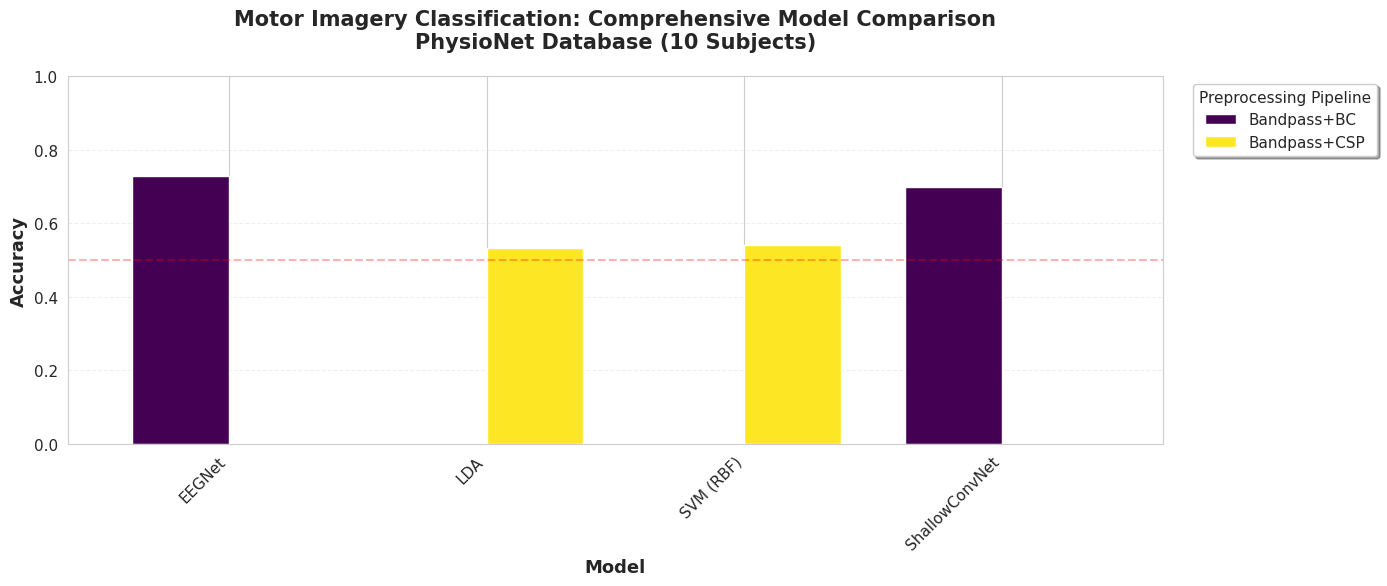

  ✓ Saved: model_comparison.png


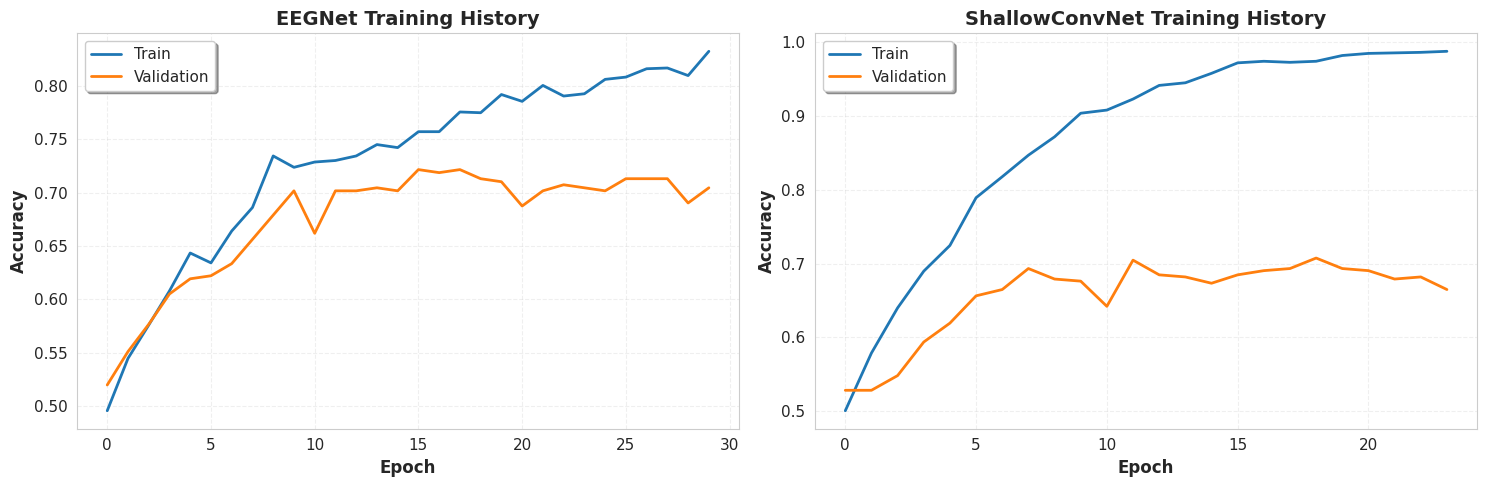

  ✓ Saved: dl_training_history.png


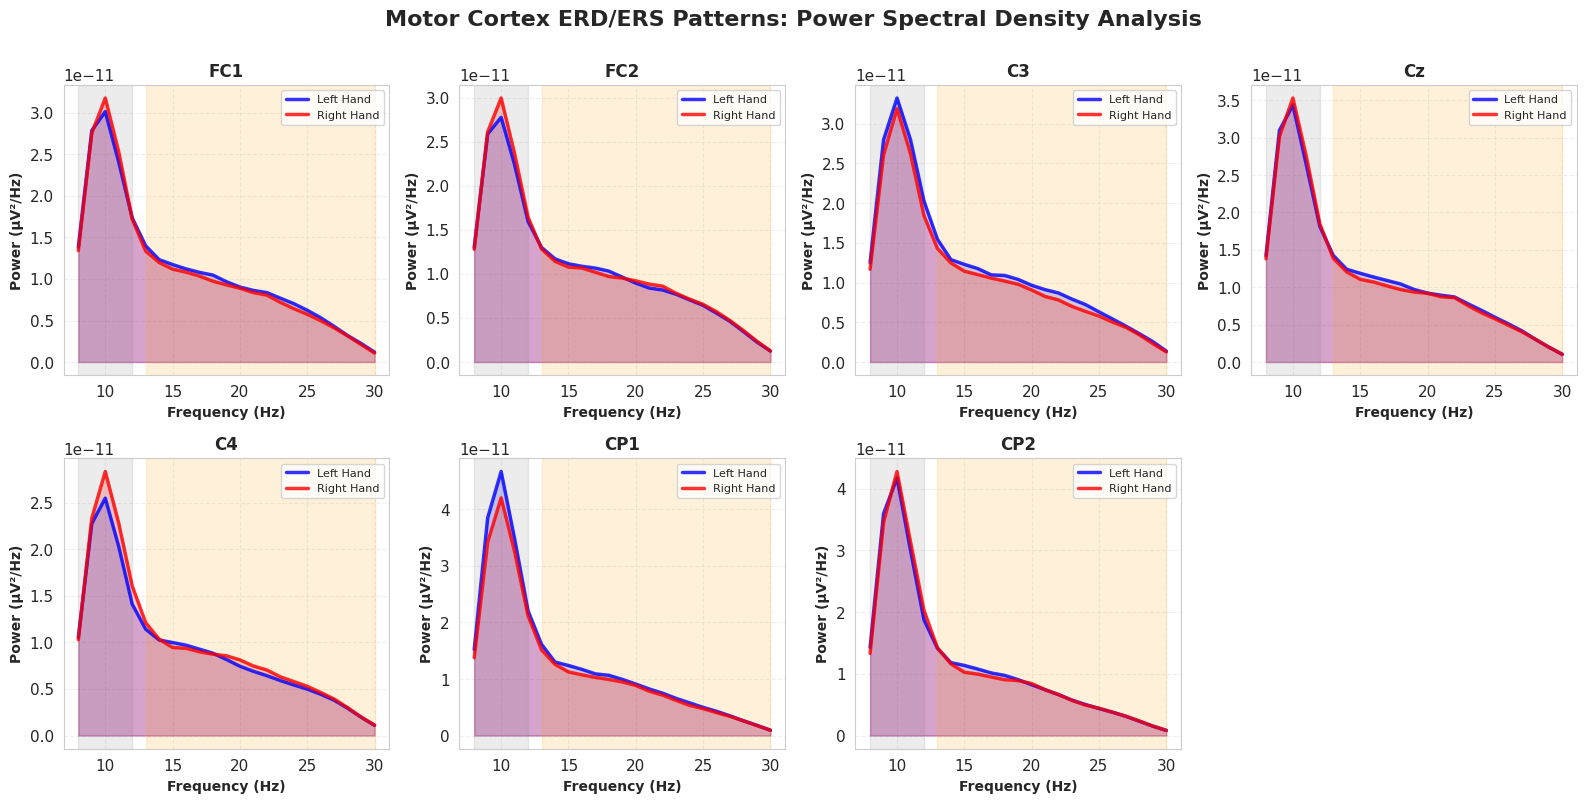

  ✓ Saved: motor_cortex_erds.png


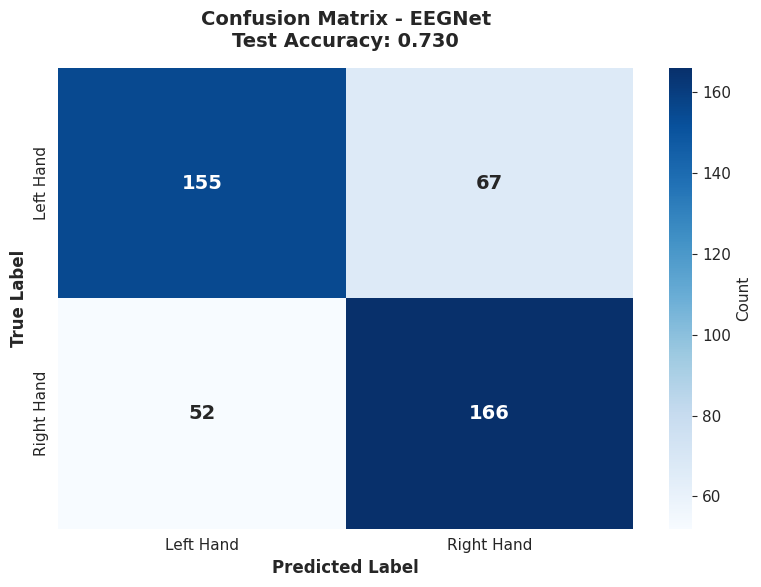

  ✓ Saved: confusion_matrix.png


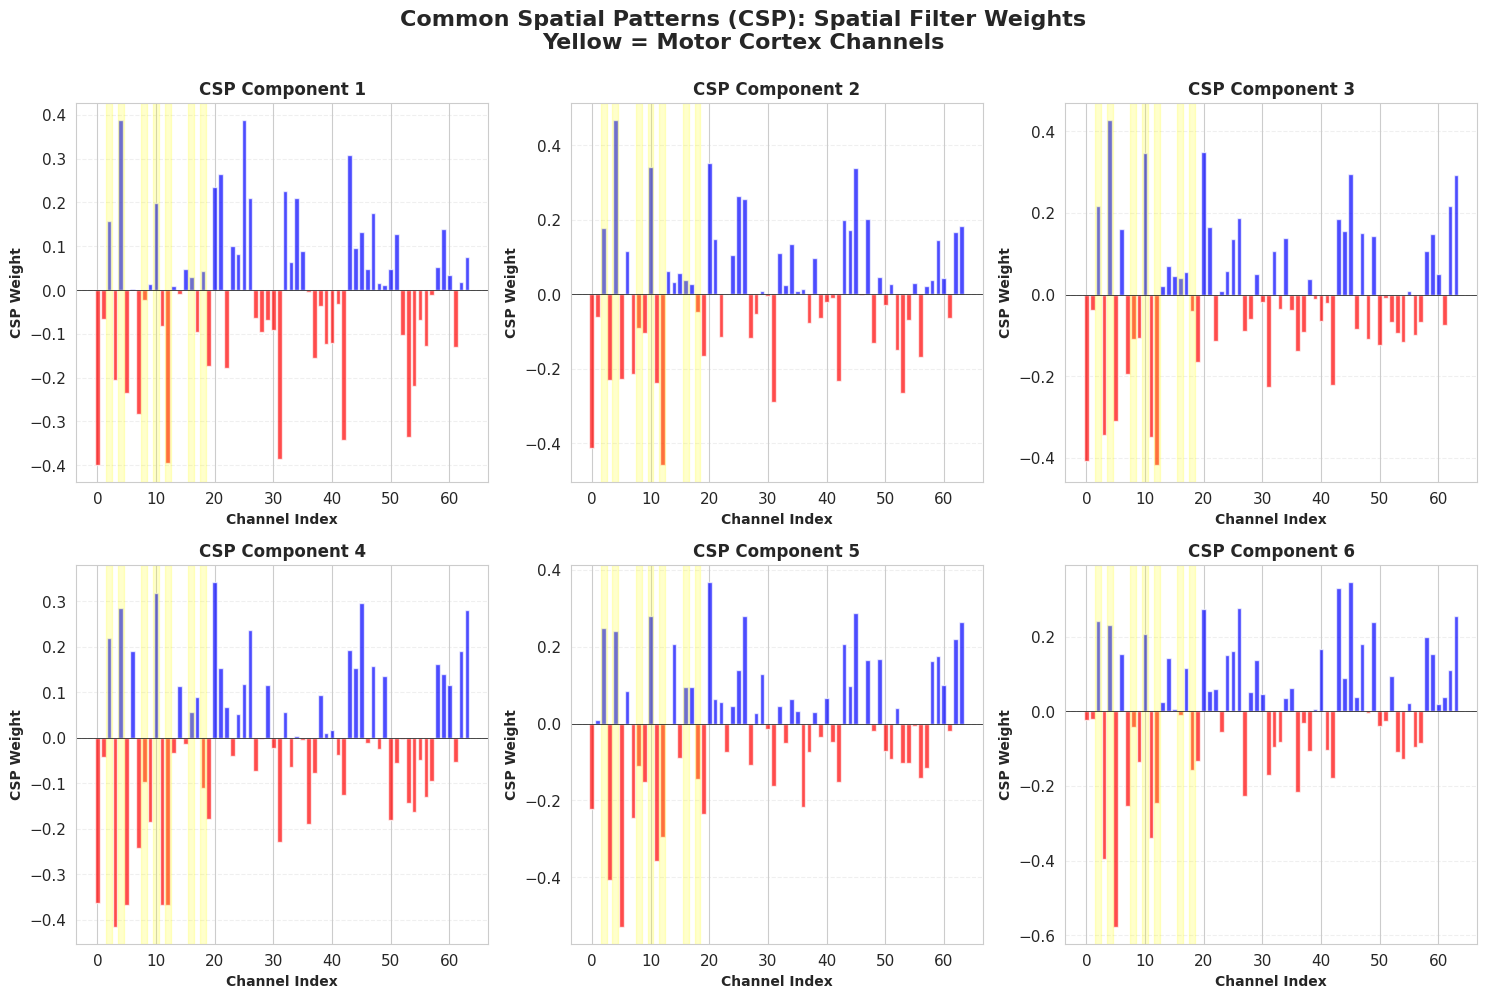

  ✓ Saved: csp_patterns.png


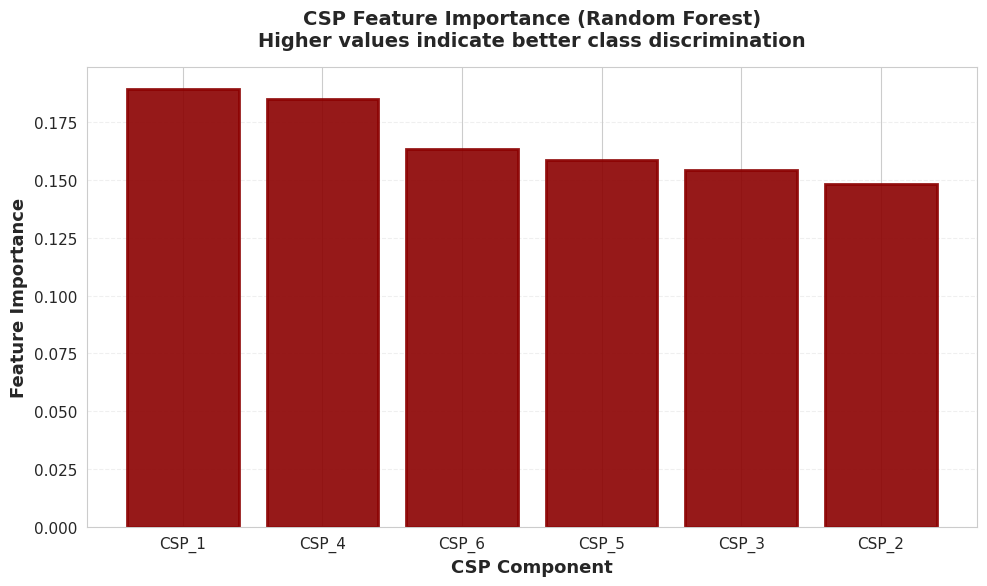

  ✓ Saved: feature_importance.png


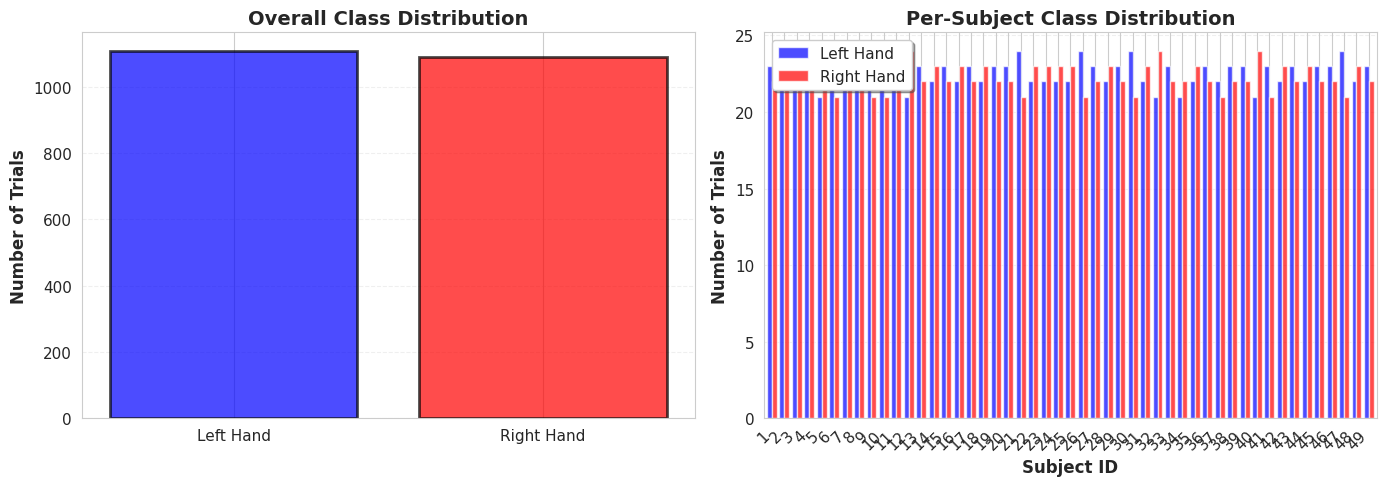

  ✓ Saved: class_distribution.png


In [8]:
# ============================================================================
# PART 9: COMPREHENSIVE VISUALIZATIONS
# ============================================================================

print("\n[8/10] Generating Visualizations...")

# 1. Model Performance Comparison
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
pivot_data = all_results.pivot(index='Model', columns='Preprocessing', values='Accuracy')
pivot_data.plot(kind='bar', ax=ax, width=0.75, colormap='viridis')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_title('Motor Imagery Classification: Comprehensive Model Comparison\nPhysioNet Database (10 Subjects)',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(title='Preprocessing Pipeline', bbox_to_anchor=(1.02, 1),
          loc='upper left', frameon=True, shadow=True)
ax.set_ylim([0, 1])
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Chance')
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: model_comparison.png")

# 2. Deep Learning Training History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_eegnet.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_eegnet.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('EEGNet Training History', fontsize=14, fontweight='bold')
axes[0].legend(frameon=True, shadow=True)
axes[0].grid(alpha=0.3, linestyle='--')

axes[1].plot(history_shallow.history['accuracy'], label='Train', linewidth=2)
axes[1].plot(history_shallow.history['val_accuracy'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('ShallowConvNet Training History', fontsize=14, fontweight='bold')
axes[1].legend(frameon=True, shadow=True)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('dl_training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: dl_training_history.png")

# 3. Motor Cortex ERD/ERS Patterns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, ch_name in enumerate(motor_ch_names[:7]):  # Plot first 7 channels
    if ch_name in erds:
        ax = axes[idx]
        freqs = erds[ch_name]['freqs']
        left_power = erds[ch_name]['left']
        right_power = erds[ch_name]['right']

        ax.plot(freqs, left_power, 'b-', linewidth=2.5, label='Left Hand', alpha=0.8)
        ax.plot(freqs, right_power, 'r-', linewidth=2.5, label='Right Hand', alpha=0.8)
        ax.fill_between(freqs, left_power, alpha=0.2, color='blue')
        ax.fill_between(freqs, right_power, alpha=0.2, color='red')

        ax.set_xlabel('Frequency (Hz)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Power (µV²/Hz)', fontsize=10, fontweight='bold')
        ax.set_title(f'{ch_name}', fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(alpha=0.3, linestyle='--')

        # Highlight mu and beta bands
        ax.axvspan(8, 12, alpha=0.15, color='gray', label='Mu')
        ax.axvspan(13, 30, alpha=0.15, color='orange', label='Beta')

# Remove extra subplot
if len(motor_ch_names) < 8:
    fig.delaxes(axes[7])

plt.suptitle('Motor Cortex ERD/ERS Patterns: Power Spectral Density Analysis',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('motor_cortex_erds.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: motor_cortex_erds.png")

# 4. Confusion Matrix (Best Model)
cm = confusion_matrix(y_test, y_pred_eegnet if best_result['Model'] == 'EEGNet' else y_pred_shallow)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            xticklabels=['Left Hand', 'Right Hand'],
            yticklabels=['Left Hand', 'Right Hand'],
            annot_kws={'size': 14, 'fontweight': 'bold'})
plt.title(f'Confusion Matrix - {best_result["Model"]}\nTest Accuracy: {best_result["Accuracy"]:.3f}',
         fontsize=14, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: confusion_matrix.png")

# 5. CSP Spatial Patterns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Get CSP patterns (spatial filters)
csp_patterns = csp.patterns_

for i in range(min(6, csp_patterns.shape[1])):
    ax = axes[i]

    # Create a simple topographic representation
    pattern = csp_patterns[:, i]

    # Bar plot of channel weights
    colors = ['red' if p < 0 else 'blue' for p in pattern]
    bars = ax.bar(range(len(pattern)), pattern, color=colors, alpha=0.7)

    ax.set_xlabel('Channel Index', fontsize=10, fontweight='bold')
    ax.set_ylabel('CSP Weight', fontsize=10, fontweight='bold')
    ax.set_title(f'CSP Component {i+1}', fontsize=12, fontweight='bold')
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Highlight motor cortex channels
    for motor_idx in motor_channel_idx:
        ax.axvspan(motor_idx-0.5, motor_idx+0.5, alpha=0.2, color='yellow')

plt.suptitle('Common Spatial Patterns (CSP): Spatial Filter Weights\nYellow = Motor Cortex Channels',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('csp_patterns.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: csp_patterns.png")

# 6. Feature Importance Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(feature_importance['CSP_Component'],
               feature_importance['Importance'],
               color='steelblue', alpha=0.8, edgecolor='navy', linewidth=2)

# Highlight most important features
max_importance = feature_importance['Importance'].max()
for i, bar in enumerate(bars):
    if feature_importance.iloc[i]['Importance'] > max_importance * 0.5:
        bar.set_color('darkred')
        bar.set_alpha(0.9)

plt.xlabel('CSP Component', fontsize=13, fontweight='bold')
plt.ylabel('Feature Importance', fontsize=13, fontweight='bold')
plt.title('CSP Feature Importance (Random Forest)\nHigher values indicate better class discrimination',
         fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: feature_importance.png")

# 7. Class Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall class distribution
class_counts = pd.Series(y_clean).value_counts().sort_index()
axes[0].bar(['Left Hand', 'Right Hand'], class_counts.values,
            color=['blue', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Trials', fontsize=12, fontweight='bold')
axes[0].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Per-subject distribution
subject_class_dist = pd.DataFrame({
    'Subject': subjects_clean,
    'Class': y_clean
})
subject_counts = subject_class_dist.groupby(['Subject', 'Class']).size().unstack(fill_value=0)
subject_counts.plot(kind='bar', ax=axes[1], color=['blue', 'red'], alpha=0.7, width=0.8)
axes[1].set_xlabel('Subject ID', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Trials', fontsize=12, fontweight='bold')
axes[1].set_title('Per-Subject Class Distribution', fontsize=14, fontweight='bold')
axes[1].legend(['Left Hand', 'Right Hand'], frameon=True, shadow=True)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: class_distribution.png")